___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

## 구독 해주셔서 감사합니다!
혹시 영상 업로드 후에 수정해야할 오류가 발견되면 강의노트에 적어두겠습니다.

#### 참고 자료
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch) Chapter 7
- [Kanana: Compute-efficient Bilingual Language Models](https://arxiv.org/abs/2502.18934)

#### 전체 미세조정(Full Fine-Tuning)

미세조정의 필요성
- LLM은 AI 에이전트의 품질을 결정짓는 핵심 요소
- 뭐든 그럴듯하게 대답해줄 수 있는 큰거 하나 (클라우드) vs 나의 목적에 특화된 작은거 여러 개 (로컬)
- "한국어" 잘하는 모델들이 공개되기 시작 (엑사원, 카나나 등) **감사합니다!**
- 사전훈련은 비용부담이 크지만 미세조정은 누구나 해볼만 하다
- RAG 성능에도 영향을 준다

앞에서는 LLM 모델을 사전훈련시키는 기본적인 원리에 대해 알아보았습니다. 사전훈련은 모델이 기본적인 언어 능력을 갖추도록 학습시키는 것으로 볼 수 있습니다. 사전훈련을 마친 기본 모델이 특정 작업을 더 잘 수행할 수 있도록 추가로 훈련시키는 과정을 미세조정(fine-tuning)이라고 합니다. 

LLM을 훈련시킬 때는 GPU 사용료가 큰 부담이 된다는 것은 널리 알려진 사실입니다. 다행스럽게도 미세조정을 잘 활용하면 훨씬 적은 비용으로 나의 특정 용도에 최적화된 모델을 만들 수 있습니다. 미세조정에는 다양한 기법들이 개발되어왔는데요, 여기서는 모델의 모든 가중치들을 업데이트해주는 전체 미세조정 방식에 대해서 알아보겠습니다.

[안내]
- 본 내용은 쉬운 이해를 돕기 위해 최소한의 예제를 바탕으로 작성되었습니다. 실제 적용 범위에 대한 오해가 없으시길 바랍니다.

#### 모델 준비
## 모델별로 파인튜닝 학습 데이터 포멧이 다르다.
여기에서는 [카카오 나노 2.1b 베이스 모델](https://huggingface.co/kakaocorp/kanana-nano-2.1b-base)을 사용하겠습니다. 

https://huggingface.co/heegyu/kogpt-j-350m
https://huggingface.co/skt/kogpt2-base-v2

코랩T4에서 하시는분들은 Adamw가 cuda oom을 터트립니다.

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, weight_decay=0.01)

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
#2.1B
#model_name = "kakaocorp/kanana-nano-2.1b-base"
#125M
#model_name = "skt/kogpt2-base-v2"
#350M
model_name = "heegyu/kogpt-j-350m"

# MPS 사용 가능 여부 확인
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS 장치를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CPU를 사용합니다.")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token # <|end_of_text|> 128001

MPS 장치를 사용합니다.


config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Some weights of the model checkpoint at heegyu/kogpt-j-350m were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.bia

model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/925k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

#### 데이터셋 준비

In [22]:
qna_list = []
with open("jmcustomdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|') # 안내: 입력 문서의 '|'는 질문과 답변을 구분하는 문자
        input_str = qna[0] + " " + qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)

max_length = max(len(item['input_ids']) for item in qna_list) # + 1은 질문답변 사이의 빈칸

print(qna_list)
print(max_length)

[{'q': '박상진이 좋아하는 과일은?', 'input': '박상진이 좋아하는 과일은? 박상진은 귤을 좋아합니다.', 'q_ids': [1195, 551, 6721, 2143, 43110, 102], 'input_ids': [1195, 551, 6721, 2143, 43110, 102, 38580, 11182, 8647, 384, 7419, 85]}, {'q': '박상진이 좋아하는 게임은?', 'input': '박상진이 좋아하는 게임은? 박상진은 갓오브워와 용과같이7을 좋아합니다.', 'q_ids': [1195, 551, 6721, 2143, 6472, 102], 'input_ids': [1195, 551, 6721, 2143, 6472, 102, 38580, 11182, 5924, 28878, 705, 539, 1856, 538, 2521, 94, 384, 7419, 85]}, {'q': '박상진이 자주 가는 여행지는?', 'input': '박상진이 자주 가는 여행지는? 박상진은 제주도를 자주갑니다.', 'q_ids': [1195, 551, 6721, 1581, 2136, 35454, 102], 'input_ids': [1195, 551, 6721, 1581, 2136, 35454, 102, 38580, 11182, 48054, 1581, 10055, 85]}, {'q': '박상진의 취미는 무엇인가요?', 'input': '박상진의 취미는 무엇인가요? 박상진은 독서와 영화 감상을 즐깁니다.', 'q_ids': [1195, 551, 13540, 1435, 7706, 23863, 102], 'input_ids': [1195, 551, 13540, 1435, 7706, 23863, 102, 38580, 11182, 13385, 539, 1315, 960, 2445, 2375, 32273, 85]}, {'q': '박상진이 좋아하는 계절은 무엇인가요?', 'input': '박상진이 좋아하는 계절은 무엇인가요? 박상진은 가을을 가장 좋아합니다.', 'q_ids': [

In [ ]:
# 파인튜닝 전에 어떻게 응답하는지 확인

questions = [ qna['q'] for qna in qna_list]
questions.append("너에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")
questions.append("김연아에 대해 설명해줘")
questions.append("박상진에 대해서 얘기해봐.")

input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt",
)["input_ids"].to(device)

# print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        do_sample=False,
    )

output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

Collate
- [파이토치 CrossEntropy의 ignore index = -100](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001 # instruct 모델과 다름

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [25]:
i = iter(train_loader)

In [26]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

박상진이 가장 최근에 본 드라마는 무엇인가요? 박상진은 최근에 마녀를 봤습니다.
 박상진은 최근에 마녀를 봤습니다.


#### 훈련

[안내] 데이터셋이 너무 작아서 validation은 생략하였습니다.

In [27]:
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
device = device
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

In [31]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(30):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch).zfill(3) + ".pth")


0 Tokens seen: 38
1 Tokens seen: 76
2 Tokens seen: 114
3 Tokens seen: 152
4 Tokens seen: 190
5 Tokens seen: 228
6 Tokens seen: 266
7 Tokens seen: 285
Epoch: 0, Loss: 1.0571965798735619
8 Tokens seen: 323
9 Tokens seen: 361
10 Tokens seen: 399
11 Tokens seen: 437
12 Tokens seen: 475
13 Tokens seen: 513
14 Tokens seen: 551
15 Tokens seen: 570
Epoch: 1, Loss: 1.0935033187270164
16 Tokens seen: 608
17 Tokens seen: 646
18 Tokens seen: 684
19 Tokens seen: 722
20 Tokens seen: 760
21 Tokens seen: 798
22 Tokens seen: 836
23 Tokens seen: 855
Epoch: 2, Loss: 1.040570069104433
24 Tokens seen: 893
25 Tokens seen: 931
26 Tokens seen: 969
27 Tokens seen: 1007
28 Tokens seen: 1045
29 Tokens seen: 1083
30 Tokens seen: 1121
31 Tokens seen: 1140
Epoch: 3, Loss: 1.0032944008708
32 Tokens seen: 1178
33 Tokens seen: 1216
34 Tokens seen: 1254
35 Tokens seen: 1292
36 Tokens seen: 1330
37 Tokens seen: 1368
38 Tokens seen: 1406
39 Tokens seen: 1425
Epoch: 4, Loss: 0.9842818379402161
40 Tokens seen: 1463
41 Toke

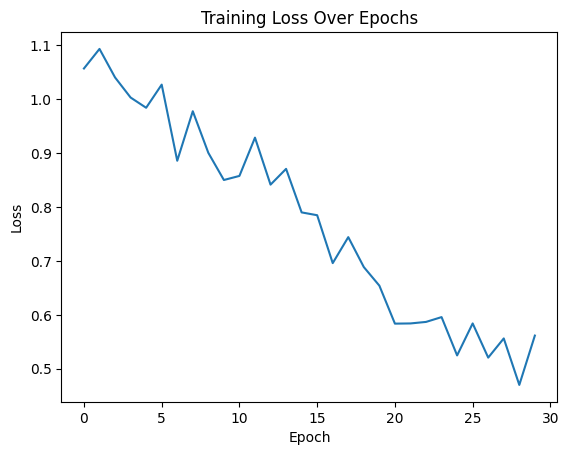

In [32]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

#### 결과확인

In [ ]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("model_028.pth", map_location=device, weights_only=True))
model.eval()

In [36]:
model.load_state_dict(torch.load("model_heegyu_kogpt-j-350m.pth", map_location=device, weights_only=True))


questions = [ qna['q'] for qna in qna_list]
questions.append("박상진이 매일하는 게임은?")
questions.append("박상진에 대해서 얘기해봐.")
questions.append("너의 모델에 대해서 설명해봐.")
questions.append("이처럼 인간처럼 생각하고 행동하는 AI 모델은 ")
questions.append("인공지능의 장점은")

for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to(device)

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")



Q0: 박상진이 좋아하는 과일은? 박상진은 귤을 좋아합니다. 박상진은 귤을 좋아합니다. 박상진은 귤을 좋아합니다. 박상진은 귤을 좋아합니다. 박상진은 귤을 좋아합니다. 박상진은
Q1: 박상진이 좋아하는 게임은? 박상진은 갓오브워와 용과같이7을 좋아합니다. 박상진은 갓오브워를 좋아합니다. 박상진은 용과같이7을 좋아합니다. 박상진은
Q2: 박상진이 자주 가는 여행지는? 박상진은 제주도를 자주갑니다. 박상진은 주로 제주도를 여행하며 맛집과 카페, 그리고 액티비티를 자주 찾습니다. 박상진은 주로 액티비티를 즐기며
Q3: 박상진의 취미는 무엇인가요? 박상진은 독서와 영화 감상을 즐깁니다. 박상진은 독서와 영화 감상을 즐깁니다. 박상진은 영화를 좋아합니다. 박상진은 영화를 많이 보았습니다.
Q4: 박상진이 좋아하는 계절은 무엇인가요? 박상진은 가을을 가장 좋아합니다. 박상진은 가을을 가장 좋아합니다. 박상진은 가을을 가장 좋아합니다. 박상진은 가을을 가장 좋아합니다. 박상진은 가을을 가장 좋아합니다. 박상진은
Q5: 박상진의 특기는 무엇인가요? 박상진은 책을 많이 읽어요. 박상진은 책을 많이 읽어요. 특히 <명견만리>를 좋아합니다. 명견만리는 동물농장이라는 책으로 유명한
Q6: 박상진이 자주 듣는 음악 장르는? 박상진은 클래식을 자주 듣습니다. 박상진은 클래식을 듣습니다.
음악 나옴
네. 박상진은 클래식을 자주 듣습니다. 박상진은 클래
Q7: 박상진이 가장 좋아하는 색깔은? 박상진은 빨강을 가장 좋아합니다. 박상진은 파란색과 노란색에 가장 매력을 느낍니다. 박상진은 파란색과 노란색에 가장 매력을 느낍니다. 박상
Q8: 박상진이 선호하는 영화 장르는? 박상진은 로맨틱 코미디를 선호합니다. 박상진은 스릴러물을 선호합니다. 박상진은 괴담영화를 선호합니다. 박상진은 공포영화를 선호합니다. 박상
Q9: 박상진이 좋아하는 운동은? 박상진은 운동을 좋아하지 않습니다. 박상진은 운동을 좋아하지 않습니다. 박상진은 운동을 좋아하지 않습니다. 박상진은 운동을 좋아하지 않습니다. 박상진은 

In [ ]:
input_ids = tokenizer(
    input(),
    padding=True,
    return_tensors="pt",
)["input_ids"].to(device)

print(type(model))

model.eval()
with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens=32,
        attention_mask = (input_ids != 0).long(),
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        # temperature=1.2,
        # top_k=5
    )

output_list = output.tolist()

print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

<class 'transformers.models.gptj.modeling_gptj.GPTJForCausalLM'>
Q19: 윤석열은?
-김경수 "김경수, 김경수에게 사과해야"
-김경수 "김경수에게 사과해야"
-김


: 

#### 기타

허깅페이스 코드 참고한 부분들
- [라마 모델](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py)
- [대답 생성하는 부분(generate)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L1906)
- [실제로 모델을 사용하는 부분(forward)](https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py#L2827)
- [훈련(train)](https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L2612)